In [76]:
%%capture

!pip install bs4
!pip install nbformat
!pip install pandas
!pip install geopandas
!pip install requests
!pip install --upgrade xlrd
!pip install openpyxl
!pip install seaborn

In [3]:
%%capture

%run ./Tidy.ipynb

# Phase de modélisation: tentative de prédiction de la consommation et de la légalisation

Dans cette seconde phase du projet, nous allons nous appuyer sur les statistiques descriptives produites juste avant afin d'orienter nos choix de modélisation.

Nous allons ici présenter les deux approches que nous avons prises. En effet, nous avions d'abord en tête avec ce projet d'essayer de prédire la légalisation ou non du cannabis dans un pays donné à partir des données mises à disposition par l'EUDA. Cette première approche s'est avérée infructueuse après de nombreux essais; et nous expliquerons les raisons de cet échec et les conclusions que nous en avons tiré dans une partie "bonus", à la fin de ce notebook. En effet, même si le modèle obtenu n'était pas performant, il nous a tout de même permis de tirer des conclusions intéressantes sur notre jeu de données.

La principale raison pour laquelle ce premier modèle s'est avéré infructueux tenait notamment au manque de données disponibles, et au nombre restreint d'observations à notre disposition. Nous avons alors mis en place plusieurs solutions à ce problème:

- En premier lieu, nous avons changé la variable à prédire. Plutôt que de se concentrer sur la législation, trop peu corrélée aux données disponibles, nous nous attacherons plutôt à tenter d'estimer la part de la consommation de cannabis dans chaque pays, en utilisant des variables socioéconomiques. Cela exige alors de changer de modèle, en abandonnant le classifieur initialement prévu à différents modèles de régression.

- Ensuite, nous avons tenu à rassembler des données plus conséquentes sur chaque pays, afin d'entraîner plus finement chaque modèle. On a ainsi pu récupérer en complément des données sur la consommation de drogues, d'autres données sur les admissions à l'hôpital liées à la consommation de drogues, sur le nombre d'infractions commises liées au trafic, ou encore des données macroéconomiques simples sur chaque pays (PIB, IDH, tau de criminalité...). On espère ainsi pouvoir entraîner un modèle plus performant

## 1. Phase de préparation des données

Comme à chaque fois que l'on souhaite entraîner un modèle, **il convient avant tout de préparer et nettoyer les données au préalable.** Nous effectuerons cette tâche selon le schéma suivant:

1. Tout d'abord la collecte et la restriction, dans la masse de données mises à notre disposition, des seules variables qui nous intéressent réellement afin d'effectuer notre entraînement, en ignorant les variables moins intéressantes afin d'obtenir un *dataframe* clair et lisible, ne contenant aucun **NaN** ou valeur nulle.

2. Ensuite la préparation de ces données, notamment la standardisation et la normalisation de celles-ci afin de pouvoir effectuer notre régression correctement.

### 1.1 Nettoyage et restriction des données

#### 1.1.1 Une fonction d'agrégation bien utile

Le premier problème à régler est le suivant: dans notre jeu de données nous disposons de beaucoup de variables identiques, relevées année par année. Or il se peut dans beaucoup de cas que l'on dispose de données récentes pour certains pays, mais pas pour d'autres pour lesquels il faut remonter quelques années en arrière. Cela a pour conséquence un jeu de donnée très troué, avec beaucoup de **NaN** dont on aimerait se débarrasser.

Afin de limiter au maximum le nombre de données vides, **on se décide alors à ne garder pour chaque pays que les données les plus récentes disponibles**. Cela nous permet de minimiser le nombre de valeurs manquantes puisqu'au lieu de ne considérer que l'année ou il y a le moins de trous, on écrase toute les années en ne gardant que la donnée la plus récente (ce qui soit dit en passant a tout de même un sens; utiliser le chiffre le plus récent semble plus raisonnable que de choisir arbitrairement l'année pour laquelle on a le plus de données)

Cela est implémenté par une simple fonction, qui fonctionne sur notre structure de donnée définie au préalable (pour plus d'informations, se référer à la deuxième partie du Notebook `Tidy.ipynb`)

In [4]:
def get_latest_data(df, new_df, variable):
    """ Parcours la table pour créer une nouvelle variable qui prend en compte les données les plus récentes disponibles
        Ce afin de pallier aux fait qu'on manque de données récentes pour certaines variables"""

    columns = list(df.columns.values)
    good_col = []

    new_df['Country'] = df['Country']

    for i in range(len(columns)):
        if variable in columns[i]:
            good_col.append(columns[i])

    for index in df.index:
        for column in good_col:
            if pd.isna(df.at[index, column]) == False:
                new_df.at[index, variable] = df.at[index, column]
                break

    new_df.dropna(inplace = True)

    return new_df

#### 1.1.2 Choix des données pour la régression linéaire

Après l'échec de la mise en place de notre classifieur (voir la partie bonus), nous avons conclu que la principale difficulté à surmonter était le **manque d'individus disponibles dans notre base de données**. Cette difficulté est particulièrement problématique car elle tient à la nature même de notre étude, restreinte aux pays de l'Union Européenne.

On décide donc finalement de se tourner vers un modèle de régression linéaire, et ce pour plusieurs raisons:

- En premier lieu, car il semble raisonnable de pouvoir prédire une variable comme la consommation de cannabis à partir de caractéristiques socio-économiques de chaque pays, en faisant l'hypothèse que les pays aux caractéristiques similaires ont un niveau de consommation tout aussi similaire, comme nous avons pu en avoir l'intuition dans notre partie de statistiques descriptives

- En second lieu car dans l'éventualité ou notre modèle viendrait à ne pas prédire correctement, il nous resterait toute la partie descriptive et l'analyse des différents coefficients de la régression à se mettre sous la dent.

On prendra donc comme variable Y la prévalence en pourcentage, sur la vie entière et lors du mois dernier, afin de réaliser deux régression différentes et de les comparer.
Pour les variables X, on choisira principalement les variables socio-économiques mises à disposition par Eurostat, à savoir **le PIB, l'IDH, les dépenses de la sécurité sociale et le pourcentage de délinquance dans les grandes villes**.
On pourra ensuite choisir d'y ajouter d'autres données un peu plus fines de l'EUDA, comme le nombre d'admis aux urgences pour consommation de cannabis, afin d'affiner notre modèle si besoin.

On s'affaire donc dans le bloc suivant à récupérer ces données et à les agréger dans une seule table.

In [ ]:
import pandas as pd

#On récupère la prévalence
df = pd.read_csv('https://raw.githubusercontent.com/refouch/Projet_Python_2A/refs/heads/main/Data/EUDA/edr2024-gps-current-table-1.csv')

dfcurrent = df[df['Substance'] == 'Cannabis']

dfcurrentadults = dfcurrent[dfcurrent['Age'] == 'All adults (15-64)']

dfcurrentadultslf = dfcurrentadults[dfcurrentadults['Recall period'] == 'Lifetime']

dfcurrentadultslf = dfcurrentadultslf[['Country','Prevalence (%)']]

#On récupère les données socio-économiques depuis Tidy.ipynb

socio_eco = table_macro

#on effectue enfin le merge
table_regression = pd.merge(dfcurrentadultslf,socio_eco)

table_regression.set_index('Country',inplace=True)

table_regression.head()

,Prevalence (%),PIB_r_hab,IDH,depenses_soc,delinquance_ville%
Country,,,,,
Austria,22.7,42540,0.916,136092.99,10.9
Belgium,22.6,40180,0.937,160905.04,29.6
Bulgaria,8.7,8660,0.795,16049.73,33.1
Croatia,22.9,14580,0.858,14133.97,2.2
Cyprus,18.0,28860,0.896,5827.16,6.1


### 1.2 Analyse exploratoire des données.

On effectue une première analyse sur les données que l'on souhaite fournir à notre modèle, afin d'en évaluer la pertinence et de pouvoir éventuellement corriger leur distribution par la suite, avec des normalisations et des standardisations.

On commence par étudier la distribution de la variable cible.

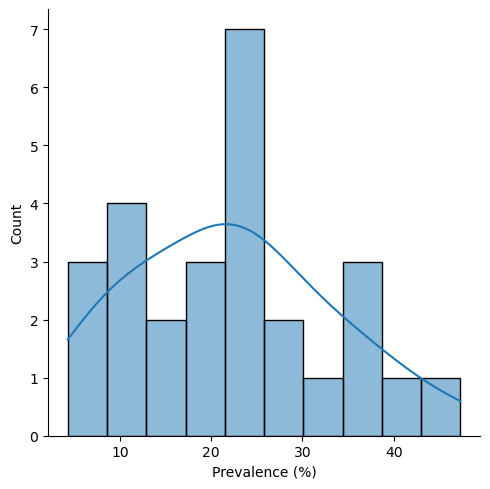

In [80]:
import seaborn as sns

sns.displot(data=table_regression,x='Prevalence (%)',bins = 10, kde=True)

On retrouve donc une distribution normale plutôt classique, quoiqu'un petit peu écrasée sur la gauche. On ne constate pas vraiment non plus la présence d'outliers dans notre variable à prédire, ce qui est plutôt bon signe.

On trace ensuite la matrice de corrélation entre nos différentes variables, afin de pouvoir mieux sélectionner celles qui nous seront utiles ou non.

<Axes: >

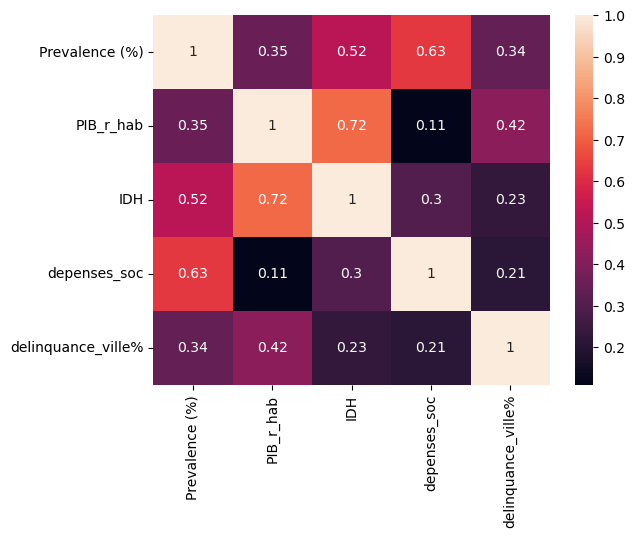

In [81]:
correlation_matrix = table_regression.corr().round(2)
sns.heatmap(data=correlation_matrix, annot=True)

On observe, entre autres:

- Que notre variable cible n'est jamais très fortement corrélée à l'une ou l'autre des variables, mais qu'elle est le plus corrélée avec l'IDH et avec les dépenses de la sécurité sociale. Ce seront donc deux pistes à privilégier.
Il nous faudra cependant bien étudier à part chaque variable. On sait de par notre analyse descriptive que l'IDH présente une variance très faible, ce qui la rend en soi peut utile pour distinguer les pays entre eux.

- On remarque en outre que le PIB et l'IDH sont fortement corrélés. c'est une chose à prendre en compte dans notre régression puisque cette corrélation pourra être vecteur de biais. On se rappelle donc de ne pas utiliser ensemble pour l'entraînement de notre modèle.

On choisit donc de se concentrer sur l'IDH et les dépenses de la sécurité sociale, on essaie avant tout d'observer leur distribution et de chercher d'éventuels outliers à retirer.

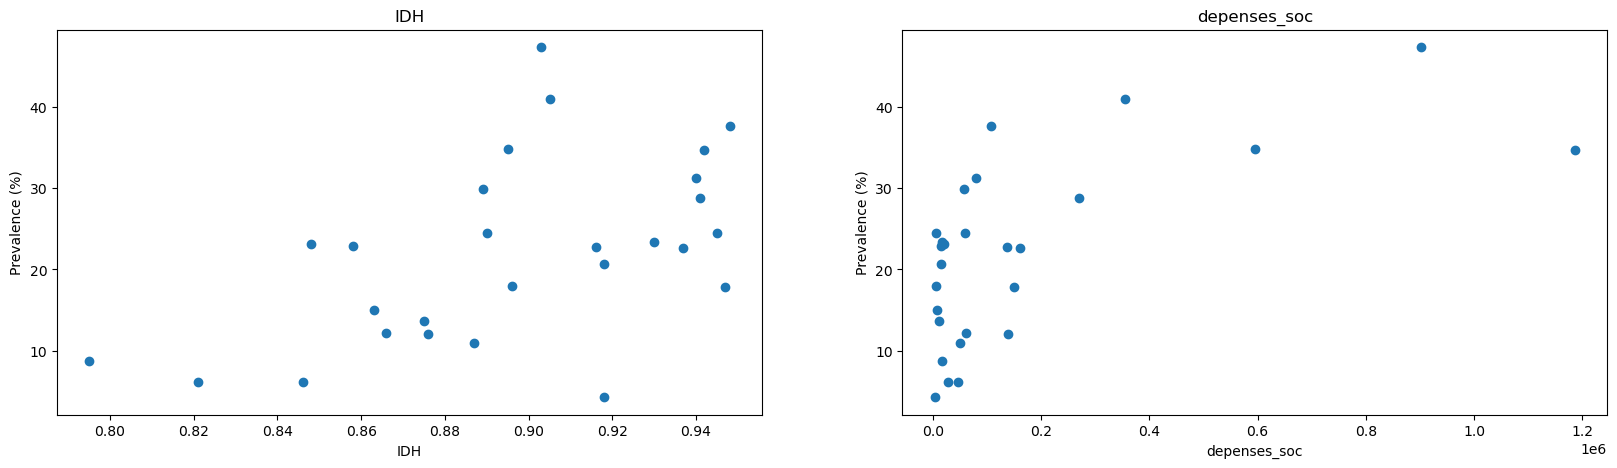

In [106]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 5))
features = ['IDH', 'depenses_soc']
target = table_regression['Prevalence (%)']
for i, col in enumerate(features):
    plt.subplot(1, len(features) , i+1)
    x = table_regression[col]
    y = target
    plt.scatter(x, y, marker='o')
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel('Prevalence (%)')

Dans le cas de l'IDH on retrouve notre légère corrélation entre nos deux variables, bien qu'elle doit plutôt éparse.

Pour les dépenses de la sécurité sociale, on a bien une corrélation mais on semble retrouver quelques outliers dont les dépenses sont bien supérieures à celles des autres pays. On va alors tenter de les éliminer afin de ne pas induire notre modèle en erreur.

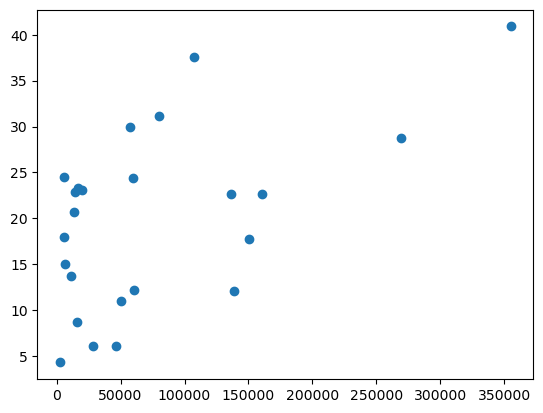

In [113]:
table_regression_fixed = table_regression.drop(index=['France','Germany','Italy'])

x = table_regression_fixed['depenses_soc']
y = table_regression_fixed['Prevalence (%)']
plt.scatter(x, y, marker='o')

Même si on perd ainsi la France, l'Italie et l'Allemagne, on se retrouve avec un distribution bien plus compacte, sans valeur extrême, qui nous semble plus adaptée afin de faire tourner notre modèle.

On regarde enfin la distribution de chacune de nos deux variables afin de déterminer les éventuels ajustements à appliquer.

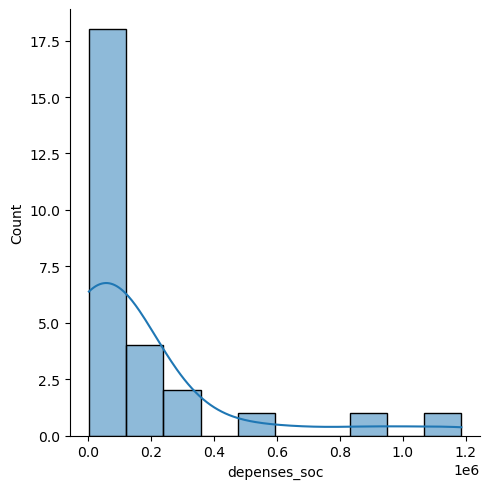

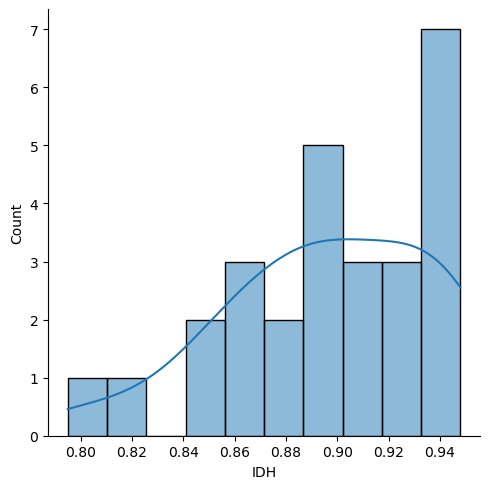

In [121]:
sns.displot(data=table_regression,x='depenses_soc',bins = 10, kde=True)
sns.displot(data=table_regression,x='IDH',bins = 10, kde=True)

On note alors plusieurs choses à régler sur nos deux variables:

- Les dépenses de la sécurité sociale ont une distribution fortement concentrée sur la gauche. On essaiera donc d'appliquer une standardisation des données pour obtenir une distribution plus conforme à la variable que l'on essaie de prédire.

- L'IDH lui est (comme prévu) très aplati, avec beaucoup de valeurs similaires (entre 0.8 et 0.95). Idem, il semble pertinent de standardiser les données pour obtenir une variance de 1.

Enfin, puisque nos deux variables sont de nature très différentes (l'une entre 0 er 1, l'autre avec un ordre de grandeur immense), il faudra les normaliser toutes les deux afin de ne pas biaiser lourdement la régression dans un sens.
**C'est ce que l'on met en place immédiatement dans la partie suivante**

## 2. Mise en place de la régression linéaire

### 2.1 Entraînement du modèle

On commence par une préparation classique de nos données. Tout d'abord on les découpes en échantillon d'entraînement et de test, en gardant ~20% de la masse totale de données pour tester notre modèle. 

On applique ensuite nos deux processus de standardisation et de normalisation à l'aide des outils de preprocessing intégrés à Scikit.

In [164]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

Y = table_regression['Prevalence (%)']
X = table_regression[['IDH', 'depenses_soc']]

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2,random_state = 243)

X_train = preprocessing.normalize(X_train)
X_test = preprocessing.normalize(X_test)

scaler = preprocessing.StandardScaler()

scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

Une fois nos données préparées, on peut entraîner notre modèle de régression linéaire afin de tenter de prédire la prévalence pour chaque pays.

In [163]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

lm = sklearn.linear_model.LinearRegression()

lm.fit(X_train,Y_train)

Y_pred = lm.predict(X_test)

print("La performance du modèle pour l'échantillon de test: \n----------")
print('Le score R² du modèle est:', r2_score(Y_test,Y_pred))
print("L'erreur quadratique moyenne est égale à", np.sqrt(mean_squared_error(Y_test, Y_pred)))

La performance du modèle pour l'échantillon de test: 
----------
Le score R² du modèle est: 0.014393602990983245
L'erreur quadratique moyenne est égale à 6.596719841283688


### 2.2 Conclusions

Comme on pouvait s'y attendre, les prédictions de notre modèle sont vraiment mauvaises, et lors de notre phase de test on a même pu obtenir des scores R² négatifs, signifiant que selon le découpage, notre modèle pouvait être amené à prédire notre variable cible moins bien qu'une droite de régression horizontale...

Il faut se rendre à l'évidence: notre jeu de données n'est tout simplement pas adapté à l'entraînement de modèles de machine learning à des fins de prédiction. Il ne nous est pas non plus possible de régler ce problème sans complètement rayer tout le travail effectué. En somme, il nous faudrait changer complètement de sujet.

Nous avons tout de même essayé de tirer le maximum du jeu de données à notre disposition. **En effet, si les résultats obtenus ne sont pas à la hauteur de nos espérances, nous avons tout de même pu tirer de nombreuses leçons de la réalisation de ce projet**

Nous avons donc essayé au maximum de mettre en avant dans ce Notebook la démarche entreprise, les difficultés que nous avons rencontré et les solutions envisagées. C'est donc finalement pour nous le véritable produit de notre travail, car le fait de travailler avec un *dataset* compliqué contenant beaucoup de valeurs manquantes nous a montré toute l'importance de la phase de sélection et de nettoyage de nos données, et nous a permis de nous entraîner à prendre des décisions méthodologiques parfois difficiles.
Le fruit de notre travail, nous le trouvons donc bien plus dans le chemin parcouru et l'expérience apprise que dans les résultats obtenus.

## 3. BONUS: Une première idée rejetée (classifieur)

Nous avons en premier lieu essayé de prédire la légalisation ou non du cannabis au sein d'un même pays à l'aide d'un SVM prenant en entrée la prévalence dans chaque pays.

Cette première approche n'a pas porté les fruits escomptés et ce pour plusieurs raisons, la principale étant une inadéquation entre notre jeu de données (trop faible) et le modèle choisi. Cette dernière section nous permet d'illustrer les raisons de cet échec et de tirer des conclusions sur la démarche à adopter lors du choix et de la mise en place de modèles.

### 3.1 Premier entraînement du classifieur sur des données de prévalence

On s'était d'abord restreint dans le cadre de la prédiction de la légalisation ou non du cannabis dans chaque pays, au pourcentage d'individus ayant déjà consommé du cannabis dans leur vie pour chaque pays.
On se rend alors vite compte que cette restriction nous donne un jeu de données très faible (1 observation par pays, soit seulement 29 observations). Ce qui va poser problème par la suite.

In [165]:
import pandas as pd

# On récupère la table de légalisation que l'on a nettoyé en amont

legal = legal_pays_clean

# On prend la prévalence sur la vie entière

df = pd.read_csv('https://raw.githubusercontent.com/refouch/Projet_Python_2A/refs/heads/main/Data/EUDA/edr2024-gps-current-table-1.csv')

dfcurrent = df[df['Substance'] == 'Cannabis']

dfcurrentadults = dfcurrent[dfcurrent['Age'] == 'All adults (15-64)']

dfcurrentadultslf = dfcurrentadults[dfcurrentadults['Recall period'] == 'Lifetime']

# On effectue un merge les deux tables
dfadultslf_legal = dfcurrentadultslf.join(legal, on = 'Country')

On a ensuite mis en place notre classifieur de manière classique, en utilisant les fonctions déjà fournies par ScikitLearn. Quelques remarques cependant sur la construction de notre modèle:

- On choisit de recoder les variables catégorielles sur la légalité en une variable binaire: 0 si le cannabis est Illegal, 1 si il est Légalisé ou Décriminalisé. Après plusieurs test en effet, nous avons conclu qu'il était préférable de se limiter à une variable binaire et de ne pas marquer la spécificité de la décriminalisation, notre jeu de données étant déjà suffisamment restreint.

- On choisit de diviser nos données de manière assez classique, en gardant un échantillon de 20% pour tester notre modèle tout en gardant 80% pour l'entraînant. Cela pose déjà un problème puisque cela ne laisse en soi que 6 observations sur lesquelles tester notre modèle, et 22 sur lesquelles l'entraîner. Ce qui amènera par la suite de fortes disparités d'une phase d'entraînement à l'autre.

- Pour notre premier essai, nous tentons simplement de fournir à notre modèle la prévalence sur la vie entière (i.e le pourcentage d'individus par pays ayant déjà fumé du cannabis dans sa vie), ainsi que la prévalence en fonction du sexe. Cela s'avèrera évidemment insuffisant, mais cela nous permettra par la suite d'illustrer au mieux les problèmes rencontrés et d'appuyer les conclusions que nous en avons tiré. Ces données on en outre le bon goût d'être de simples pourcentages, ce qui ne permet de ne pas avoir à les normaliser au préalable, ni d'avoir a se soucier d'éventuels outliers.


Ceci étant dit, nous pouvons passer à la phase d'entraînement du modèle. **Nous allons ainsi l'entraîner deux fois en prenant à chaque fois une *seed* différente** ce qui va nous permettre de démontrer l'inconstance de notre modèle, et finalement sa faible utilité.

In [ ]:
from sklearn import svm
import sklearn.metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import warnings

warnings.filterwarnings('ignore')

# Recodage des variables catégorielles et division de notre échantillon

dfadultslf_legal['Recreational_num'] = dfadultslf_legal['Recreational'].replace({'Decriminalized' : 2, 'Legal' : 1, 'Illegal' : 0})
dfadultslf_legal['Medical_num'] = dfadultslf_legal['Medical'].replace({'Decriminalized' : 2, 'Legal' : 1, 'Illegal' : 0})

X = dfadultslf_legal[['Prevalence (%)','Males (%)','Females (%)']]
Y = dfadultslf_legal['Recreational_num']

# Création de deux échantillonages différents, selon une seed prédéterminée
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2, random_state=1241)
X2_train, X2_test, Y2_train, Y2_test = train_test_split(X,Y, test_size=0.2, random_state=76835790)

# Entraînement du classifieur sur nos deux échantillonages
svm_classifier = svm.SVC(C=1, kernel='linear')

svm_classifier.fit(X_train, Y_train)
Y_pred = svm_classifier.predict(X_test)

svm_classifier.fit(X2_train, Y2_train)
Y2_pred = svm_classifier.predict(X2_test)

# Accuracy score 
accuracy_score = sklearn.metrics.accuracy_score(Y_test, Y_pred)

accuracy_score_2 = sklearn.metrics.accuracy_score(Y2_test, Y2_pred)

print('Précision du modèle après entraînement sur le premier découpage: ', accuracy_score)
print('Précision du modèle après entraînement sur le second découpage: ', accuracy_score_2)

Précision du modèle après entraînement sur le premier découpage:  0.16666666666666666
Précision du modèle après entraînement sur le second découpage:  0.8333333333333334


On remarque donc qu'en fonction de notre découpage, la précision du modèle peut s'avérer une fois très bonne, et une autre fois absolument médiocre. De cela on ne peut conclure qu'une seule chose: notre modèle prédit essentiellement au hasard (ici les deux seed ont été bien choisies pour illustrer notre démarche, mais dans la plupart des test réalisés on se retrouvait avec une *accuracy* oscillant autour de 0.5, soit l'espérance de prédire correctement une variable binaire au hasard)

Ainsi, la variable utilisée pour l'entraîner n'a qu'un pouvoir explicatif très faible sur celle que l'on cherche à prédire.
Autrement dit: la prévalence de la consommation du cannabis dans chaque pays n'est que très faiblement (voire pas du tout) corrélée à l'état de la législation dans ce pays. On pouvait en réalité déjà s'en rendre compte lors de la phase de statistiques descriptives: si la consommation de cannabis est illégale en France comme en Turquie, ces deux pays constituent les valeurs extrêmes de notre échantillon quand à la prévalence sur la vie entière (56% contre 2%)

Il devient alors évident **qu'il nous faut plus de données, et des données plus pertinentes afin d'établir un classifieur plus performant**. C'est ce que nous avons tenté de faire par la suite, et ce qui nous a posé encore d'autres problèmes, desquels nous pouvons tirer encore d'autres conclusions intéréssantes.

### 3.2 Second entraînement du classifieur, cette fois sur des données judiciaires

Notre principal problème étant le manque de corrélation entre nos variables explicatives et notre variable à prédire, nous sommes allé chercher des données de l'EUDA qui pourrait le mieux expliquer la légalisation ou non du cannabis dans un pays donné.

On s'est alors arrêté sur les données judiciaires fournies par l'agence, à savoir le nombre d'infractions commises dans chaque pays concernant la consommation, la vente, ou encore la production de cannabis.
On imagine a priori que ces nouvelles données nous permettrons de mieux prédire la légalisation ou non du cannabis dans un pays donné.


In [ ]:
import pandas as pd

# On récupère la table de légalisation que l'on a nettoyé en amont

legal = legal_pays_clean

# On prend cette fois les données judiciaires, qu'on passe par notre fonction de tri définie en amont

dfcurrent = table_infractions_legales

df_infrac = pd.DataFrame()

df_infrac = get_latest_data(dfcurrent,df_infrac,'cannabis.conso_x')
df_infrac = get_latest_data(dfcurrent,df_infrac,'cannabis.conso_y')
df_infrac = get_latest_data(dfcurrent,df_infrac,'cannabis.prod')
df_infrac = get_latest_data(dfcurrent,df_infrac,'cannabis.ventes')


#On effectue un merge les deux tables
df_infrac_legal = df_infrac.join(legal, on = 'Country')

df_infrac_legal

,Country,cannabis.conso_x,cannabis.conso_y,cannabis.prod,cannabis.ventes,Recreational,Medical
0,Austria,19909.0,19909.0,2601.0,6784.0,Decriminalized,Legal
1,Belgium,29572.0,29572.0,661.0,5805.0,Decriminalized,Legal
3,Croatia,5159.0,5159.0,252.0,1016.0,Decriminalized,Legal
4,Cyprus,563.0,563.0,18.0,166.0,Illegal,Legal
5,Czechia,6443.0,6443.0,184.0,728.0,Decriminalized,Legal
10,Germany,174876.0,174876.0,494.0,39366.0,Legal,Legal
11,Greece,5764.0,5764.0,537.0,3601.0,Illegal,Legal
12,Hungary,3437.0,3437.0,117.0,587.0,Illegal,Illegal
19,Netherlands,2413.0,2413.0,2245.0,2245.0,Decriminalized,Legal
22,Portugal,7020.0,7020.0,247.0,6112.0,Decriminalized,Legal


On voit déjà apparaître ici notre principal problème: à force d'écarter les lignes qui comportent des valeurs manquantes pour une seule des variables que l'on veut inclure, on se retrouve avec un jeu de données très restreint. C'est une situation particulièrement difficile puisque nous ne pouvons pas y faire grand chose, cela tient uniquement à l'absence de données fournies par l'EUDA pour beaucoup de pays.

On tentera tout de même d'entraîner notre modèle, mais en s'attendant à des résultats tout au plus médiocres.

**NOTE**: contrairement à notre premier entraînement du modèle, il nous est ici nécessaire de normaliser nos données pour chaque variable car les ordres de grandeurs peuvent varier d'une infraction à l'autre. Cela a donc été implémenté dans le code ci-dessous.

In [ ]:
from sklearn import svm
import sklearn.metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

# Recodage des variables catégorielles

df_infrac_legal['Recreational_num'] = df_infrac_legal['Recreational'].replace({'Decriminalized' : 1, 'Legal' : 1, 'Illegal' : 0})
df_infrac_legal['Medical_num'] = df_infrac_legal['Medical'].replace({'Decriminalized' : 1, 'Legal' : 1, 'Illegal' : 0})

X = df_infrac_legal[['cannabis.conso_x','cannabis.conso_y','cannabis.prod','cannabis.ventes']]
Y = df_infrac_legal['Recreational_num']

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2, random_state=3)

X_train = preprocessing.normalize(X_train)
X_test = preprocessing.normalize(X_test)

svm_classifier = svm.SVC(C=1, kernel='linear')

svm_classifier.fit(X_train, Y_train)

Y_pred = svm_classifier.predict(X_test)

accuracy_score = sklearn.metrics.accuracy_score(Y_test, Y_pred)

print('Précision du modèle: ', accuracy_score)
print("Taille de l'échantillon de test: ", len(Y_test))

Précision du modèle:  0.6666666666666666
Taille de l'échantillon de test:  3


On se retrouve le plus souvent avec un score de précision aux alentour de 0.66, ce qui est donc en soi un peu meilleur qu'une simple prédiction aléatoire. Cependant, il nous est impossible de tirer quoique ce soit de ce score puisque rappelons qu'il est calculé ainsi:

$Accuracy = \dfrac{VP + VN}{FP + FN + VP + VN}$

Avec VP les vrais positifs, FP les faux positifs, etc.
Autrement dit, le nombre de prédictions correctes divisées par la population totale de l'échantillon de test. Ici puisque la taille de l'échantillon de test est seulement de 3 observations, il est en réalité difficile d'inférer quoique ce soit de ce ratio. La taille de l'échantillon est donc définitivement trop faible pour que l'on puisse tirer des conclusions satisfaisantes de notre modèle.

### 3.3 Conclusions générales tirés de cet échec

On se rend donc finalement compte d'un problème général et plutôt flagrant qui frappe le jeu de données choisi: ce dernier comporte un nombre beaucoup trop faible d'observations pour tenter de faire de l'apprentissage supervisé comme nous aurions aimé le faire.

La nature même de notre sujet, qui se limite aux 27 pays membres de l'Union Européenne, rend donc bien difficile la mise en place de modèles de machine learning afin de produire des prédictions satisfaisantes et des analyses pertinentes. 

Des pistes à explorer si l'on voulait tout de même essayer de prédire l'état de la législation dans un pays donné serait alors éventuellement de ne tenter de prédire que la législation d'un seul pays, en connaissant celle des autres pays qui présenteraient des caractéristiques similaires au pays dont on essaierait de prédire la législation. 

Par manque de temps et de moyens, ce n'est pas le chemin que nous avons choisi de suivre. Fort des enseignements tirés de cet échec, nous nous sommes plutôt tournés vers la mise en place de modèle qui semblent plus adaptés au jeu de données mis à notre disposition. En effet, étant donné que nous possédons un nombre très limités d'individus (les pays), mais d'énormément de variables et d'observation pour chacun de ses individus, il nous paraît alors plus pertinent de nous tourner vers des modèles de régression linaires, qui seront plus propice à prédire et expliquer d'autres variables que la législation. Nous avons donc tenté, après cela, de nous tourner vers une prédiction de la consommation.